<a href="https://colab.research.google.com/github/mashyko/StyleGANs/blob/master/stylegan_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The code for StyleGAN v1 in TensorFlow==1.15

 adopted from  https://qiita.com/Phoeboooo/items/12d21916de56d125f0be and modified.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


make directory /stylegans/ and inside it, /stylegans_dir/

download or upload the pre-trained model 'karras2019stylegan-ffhq-1024x1024.pkl' into /stylegans_dir/

In [0]:
#!mkdir stylegans
#%cd stylegans

#!git clone https://github.com/NVlabs/stylegan.git

#%cd ..
#!mkdir stylegans_dir


In [0]:
%cd stylegans/stylegan

In [0]:
%pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 32kB/s 
     |████████████████████████████████| 3.8MB 44.3MB/s 
     |████████████████████████████████| 512kB 57.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6df06c188a8d0421e799eff09c3ff80753e978af501930f4debfc88234d24bc3
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [0]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config


# Initialize TensorFlow.
tflib.init_tf()

# Load pre-trained network.
#url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl 人物
#url = 'https://drive.google.com/uc?id=1MOSKeGF0FJcivpBI7s63V9YHloUTORiF' # stylegan-bedrooms-256x256.pkl bedroom
#url = 'https://drive.google.com/uc?id=1MJ6iCfNtMIRicihwRorsM3b7mmtmK9c3' # karras2019stylegan-cars-512x384.pkl 車 
#url = 'https://drive.google.com/uc?id=1MQywl0FNt6lHu8E_EUqnRbviagS7fbiJ' # karras2019stylegan-cats-256x256.pkl 猫

*_, Gs = pickle.load(open('../stylegans_dir/karras2019stylegan-ffhq-1024x1024.pkl','rb'))


In [0]:
# Pick latent vector.
rnd = np.random.RandomState(210)
latents = rnd.randn(1, Gs.input_shape[1])

In [0]:
# Generate image.
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

In [0]:
# Save image.
os.makedirs(config.result_dir, exist_ok=True)
png_filename = os.path.join(config.result_dir, 'example210.png')
PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

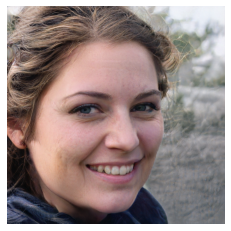

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#画像内に線を表示しない
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')
#画像の読み込み
im = Image.open("results/example210.png")
#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_seeds, dst_seeds, style_ranges):
    print(png)
    src_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in src_seeds)
    dst_latents = np.stack(np.random.RandomState(seed).randn(Gs.input_shape[1]) for seed in dst_seeds)
    src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_latents, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_seeds) + 1), h * (len(dst_seeds) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_seeds))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)


def load_Gs(url):
    if url not in _Gs_cache:
        with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
            _G, _D, Gs = pickle.load(f)
        _Gs_cache[url] = Gs
    return _Gs_cache[url]

url_ffhq = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
_Gs_cache = dict()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)


In [0]:
draw_style_mixing_figure(os.path.join(config.result_dir, 'figure03-style-mixing15.png'), load_Gs(url_ffhq),
                         w=1024, h=1024, src_seeds=[3,48,6,63,13,68], dst_seeds=[36,18,26,29,33,84],
                         style_ranges=[range(0,4)]*3+[range(4,8)]*2+[range(8,18)]*1)

results/figure03-style-mixing15.png


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


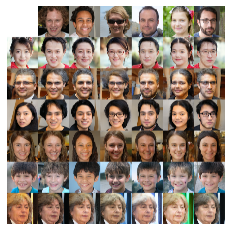

In [0]:
#画像内に線を表示しない
fig,ax = plt.subplots()
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.set_xticklabels([]) 
ax.axis('off')
#画像の読み込み
im = Image.open("results/figure03-style-mixing15.png")
#画像をarrayに変換
im_list = np.asarray(im)
#貼り付け
plt.imshow(im_list)
#表示
plt.show()

以上